# Accomodation Price Prediction AirBnb - Boston Area

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

from scipy.stats import skew, kurtosis

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Extraction

In [3]:
listings = pd.read_csv('listings_bst.csv')
reviews  = pd.read_csv('reviews_bst.csv')
calendar = pd.read_csv('calendar_bst.csv')

pd.set_option('display.max_columns', None)

listings.shape

(3585, 95)

### Check for missing data

In [4]:
#every column that has more than 30% of missing data, will be dropped
total = listings.isna().sum().sort_values(ascending=False)
percent = (listings.isna().sum()/len(listings)).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
neighbourhood_group_cleansed,3585,1.000000
jurisdiction_names,3585,1.000000
license,3585,1.000000
has_availability,3585,1.000000
square_feet,3529,0.984379
monthly_price,2697,0.752301
weekly_price,2693,0.751185
security_deposit,2243,0.625662
notes,1975,0.550907
interaction,1554,0.433473


In [5]:
def dropCol(col, df):
    '''
    INPUT: 
        col: Insert a list of columns names for multiple and a string of a column for a singular drop of column
        df: Insert the dataframe with the defined columns to be dropped
    OUTPUT:
        Modified dataframe without the column/s that has/have been dropped
    '''
    df.drop(columns = col, axis=1, inplace=True)

In [6]:
missing_data = missing_data[missing_data['Percent'] > 0.31]
drop_col = list(missing_data.index)

In [7]:
dropCol(drop_col, listings)

### Check for useless columns to drop manually

In [8]:
useless_col = ['id','scrape_id', 'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url'
              , 'host_thumbnail_url', 'host_picture_url', 'country_code']

dropCol(useless_col, listings)

### Change data types from objects to integer

In [9]:
int_col = ['cleaning_fee', 'extra_people', 'host_response_rate', 'host_acceptance_rate']
    
for col in int_col:
    listings[col] = listings[col].str.extract(r'(\d+)')
    listings[col] = pd.to_numeric(listings[col], errors='coerce')

In [10]:
day_price = listings['price'] 
day_price = day_price.apply(lambda x: x.split('.')[0]).apply(lambda x: x.split('$')[-1]) #remove $ sign and cents
day_price = day_price.str.replace(',', '')
day_price = pd.to_numeric(day_price, errors='coerce') #convert the price(object datatype) to an integer
listings['price'] = day_price

In [11]:
#extract the amenities information in the accomodation, check for the number of features/amenities
listings['n_amenities'] = listings['amenities'].apply(lambda x: len(x.replace('{', '').replace('}', '').replace('"', '').split(',')))
#Since we created a column with a number of amenities, we can drop the original column
listings.drop('amenities', axis=1, inplace=True) 

# EDA

In [12]:
listings.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,n_amenities
count,3114.000000,3114.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3571.000000,3575.000000,3576.000000,3585.000000,2478.000000,3585.000000,3585.000000,3585.000000,3.585000e+03,3585.00000,3585.000000,3585.000000,3585.000000,3585.000000,2772.000000,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,3585.000000,2829.000000,3585.000000
mean,94.989082,84.173089,58.902371,58.902371,42.340032,-71.084818,3.041283,1.221647,1.255944,1.609060,173.925802,68.380145,1.429847,10.886192,3.171269,2.872584e+04,8.64993,21.833194,38.558159,179.346444,19.044630,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,12.733891,1.970908,15.862762
std,12.517686,21.779254,171.119663,171.119663,0.024403,0.031565,1.778929,0.501487,0.753060,1.011745,148.331321,51.297835,1.056787,19.137773,8.874133,1.670136e+06,10.43533,21.860966,33.158272,142.136180,35.571658,9.531686,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,29.415076,2.120561,4.832590
min,0.000000,0.000000,0.000000,0.000000,42.235942,-71.171789,1.000000,0.000000,0.000000,0.000000,10.000000,5.000000,0.000000,0.000000,1.000000,1.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.010000,1.000000
25%,97.000000,71.000000,1.000000,1.000000,42.329995,-71.105083,2.000000,1.000000,1.000000,1.000000,85.000000,25.000000,1.000000,0.000000,1.000000,3.650000e+02,0.00000,0.000000,0.000000,19.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.480000,13.000000
50%,100.000000,94.000000,2.000000,2.000000,42.345201,-71.078429,2.000000,1.000000,1.000000,1.000000,150.000000,50.000000,1.000000,0.000000,2.000000,1.125000e+03,4.00000,16.000000,37.000000,179.000000,5.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.170000,16.000000
75%,100.000000,100.000000,7.000000,7.000000,42.354685,-71.062155,4.000000,1.000000,2.000000,2.000000,220.000000,100.000000,1.000000,20.000000,3.000000,1.125000e+03,15.00000,40.000000,68.000000,325.000000,21.000000,98.250000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.000000,2.720000,19.000000
max,100.000000,100.000000,749.000000,749.000000,42.389982,-71.000100,16.000000,6.000000,5.000000,16.000000,4000.000000,300.000000,14.000000,200.000000,300.000000,1.000000e+08,30.00000,60.000000,90.000000,365.000000,404.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,136.000000,19.150000,31.000000


<AxesSubplot:title={'center':'Price Distribution'}, xlabel='price', ylabel='Density'>

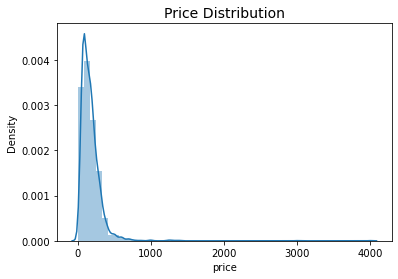

In [13]:
#Check distribution of accomodation price
plt.title('Price Distribution', fontsize=14)

sns.distplot(listings['price'])

In [14]:
#check the skewness and kurtosis
print('skewness of a normal symmetric distribution should be 0 - compared to ours: {}'.format(skew(listings['price'])))
print('excess kurtosis of a normal symmetric distribution should be 0 - compared to ours: {}'.format(kurtosis(listings['price'])))

skewness of a normal symmetric distribution should be 0 - compared to ours: 8.517917676910463
excess kurtosis of a normal symmetric distribution should be 0 - compared to ours: 168.11532221213594


In [15]:
#as well as our variance
print(np.var(listings['price'])) #Price fluctuates so widely

21996.04358809458


In [16]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   last_scraped                      3585 non-null   object 
 1   name                              3585 non-null   object 
 2   summary                           3442 non-null   object 
 3   space                             2528 non-null   object 
 4   description                       3585 non-null   object 
 5   experiences_offered               3585 non-null   object 
 6   host_name                         3585 non-null   object 
 7   host_since                        3585 non-null   object 
 8   host_location                     3574 non-null   object 
 9   host_response_time                3114 non-null   object 
 10  host_response_rate                3114 non-null   float64
 11  host_acceptance_rate              3114 non-null   float64
 12  host_i

In [17]:
#see correlation on numeric features
numeric_features = listings.dtypes[listings.dtypes != 'object'].index

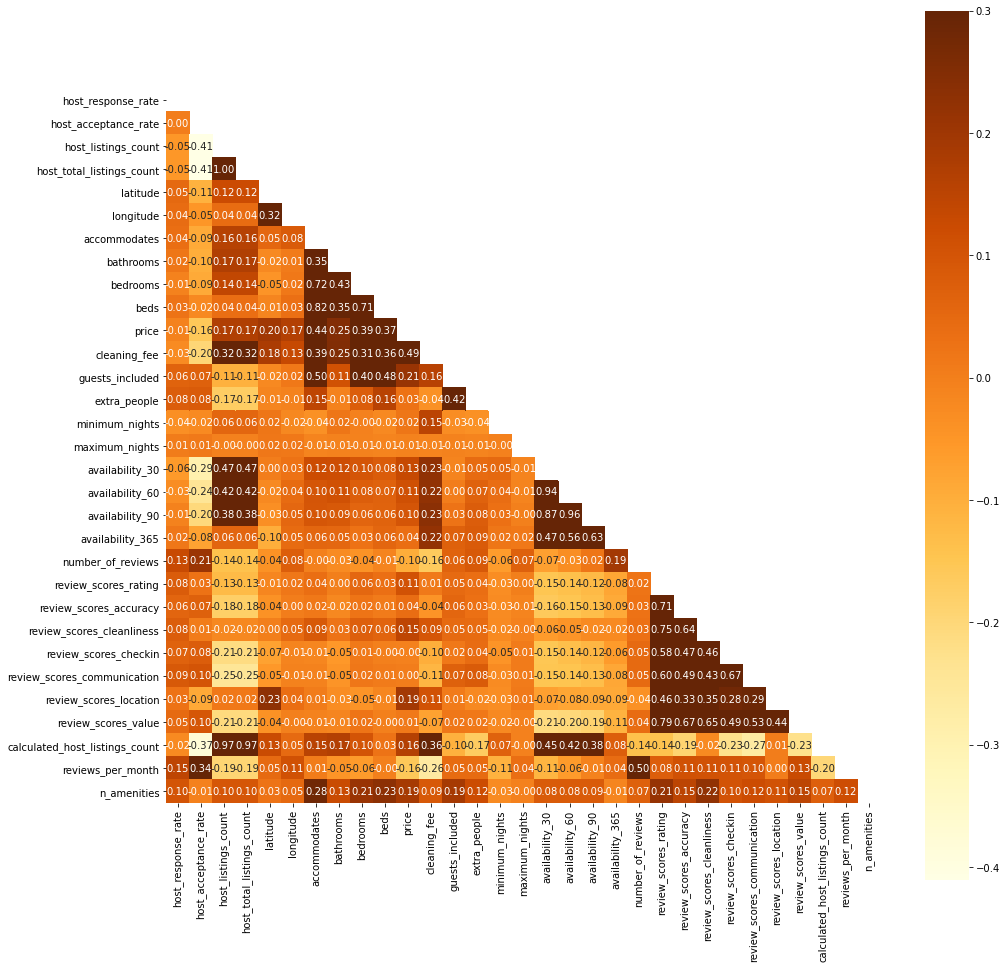

In [18]:
corrmat = listings[numeric_features].corr()

mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(16,16))   
ax = sns.heatmap(corrmat, mask=mask, vmax=.3, square=True, annot=True, fmt='.2f',cmap='YlOrBr')

### Boxplot

In [19]:
# Handling the outliers with the 1.5 x IQR rule: 220+((220-85)*1.5) = 422.5 in later stage
listings = listings[listings['price'] < 3000]
listings_plot = listings[listings['price'] < 422.5]

<AxesSubplot:xlabel='beds', ylabel='price'>

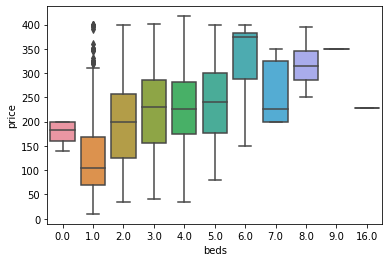

In [20]:
sns.boxplot(x='beds', y='price', data=listings_plot)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

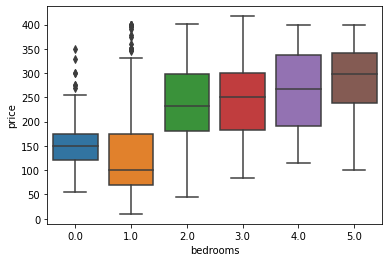

In [21]:
sns.boxplot(x='bedrooms', y='price', data=listings_plot)

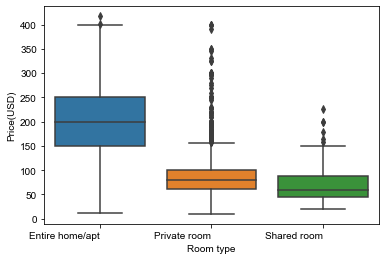

In [22]:
sns.boxplot(x='room_type', y='price', data=listings_plot)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.set_xlabel('Room type')
ax.set_ylabel('Price(USD)')
sns.set(rc={'figure.figsize':(13,6)})
plt.show()

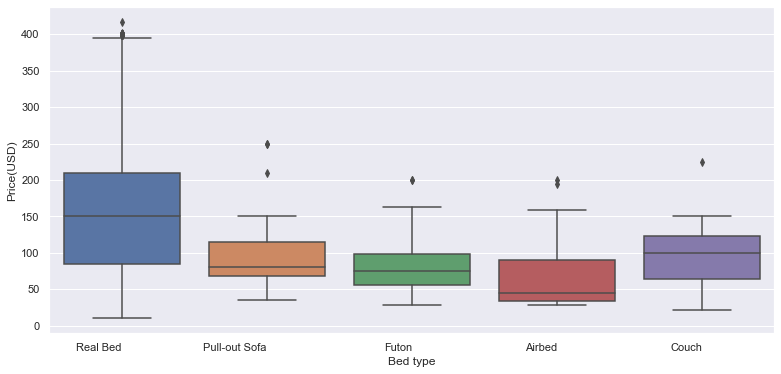

In [23]:
sns.boxplot(x='bed_type', y='price', data=listings_plot)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.set_xlabel('Bed type')
ax.set_ylabel('Price(USD)')
sns.set(rc={'figure.figsize':(13,6)})
plt.show()

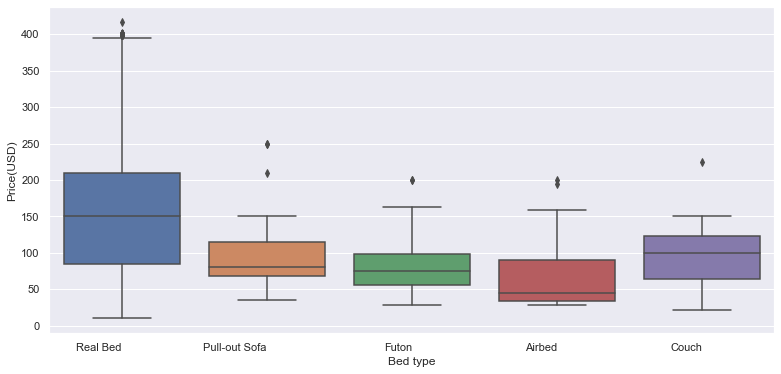

In [24]:
sns.boxplot(x='bed_type', y='price', data=listings_plot)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.set_xlabel('Bed type')
ax.set_ylabel('Price(USD)')
sns.set(rc={'figure.figsize':(13,6)})
plt.show()

In [25]:
neigh_cleansed = listings.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index
neigh_cleansed

Index(['Leather District', 'South Boston Waterfront', 'Downtown', 'Chinatown',
       'Back Bay', 'Bay Village', 'West End', 'Beacon Hill', 'Fenway',
       'Charlestown', 'South End', 'North End', 'South Boston',
       'Jamaica Plain', 'Roxbury', 'East Boston', 'Brighton', 'Mission Hill',
       'West Roxbury', 'Allston', 'Longwood Medical Area', 'Roslindale',
       'Dorchester', 'Mattapan', 'Hyde Park'],
      dtype='object', name='neighbourhood_cleansed')

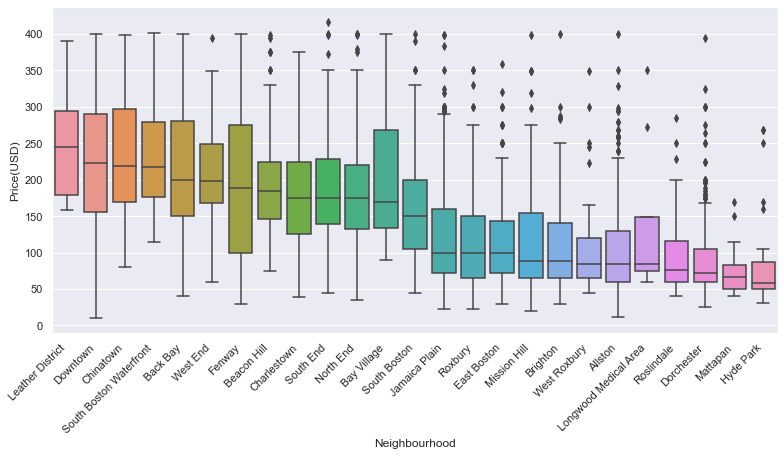

In [26]:
neigh_cleansed = listings_plot.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index

sns.boxplot(x='neighbourhood_cleansed', order=neigh_cleansed, y='price', data=listings_plot)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Neighbourhood')
ax.set_ylabel('Price(USD)')
sns.set(rc={'figure.figsize':(19,8)})
plt.show()

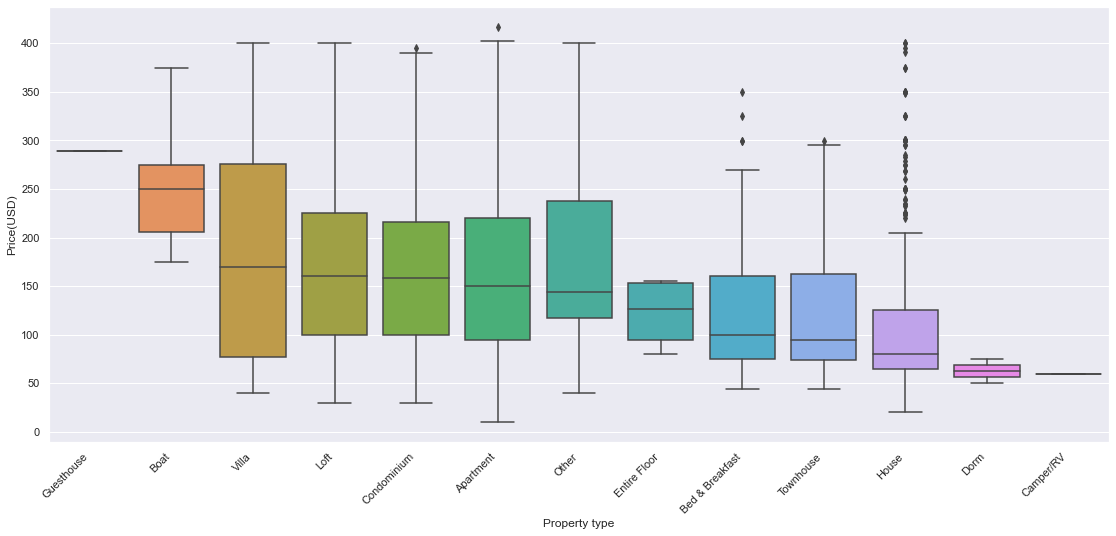

In [27]:
#check the property type
order_property_type = listings_plot.groupby('property_type')['price'].median().sort_values(ascending=False).index

sns.boxplot(x='property_type', y='price', data=listings_plot, order = order_property_type)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Property type')
ax.set_ylabel('Price(USD)')
sns.set(rc={'figure.figsize':(13,6)})
plt.show()

In [28]:
listings.price.describe()

count    3583.000000
mean      172.069216
std       125.277945
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      1400.000000
Name: price, dtype: float64

### Import basemap

In [29]:
from mpl_toolkits.basemap import Basemap

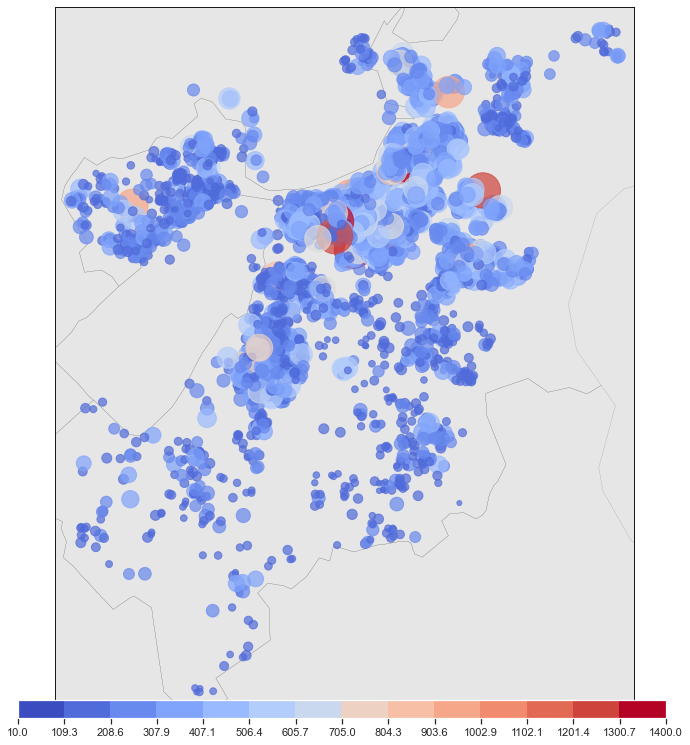

In [30]:
lat_max = listings.latitude.max()
lat_min = listings.latitude.min()
lon_max = listings.longitude.max()
lon_min = listings.longitude.min()
edge = 0.005

fig = plt.figure(figsize=(15,13))
m = Basemap(projection='merc', llcrnrlat=lat_min-edge, urcrnrlat=lat_max+edge, llcrnrlon=lon_min-edge, urcrnrlon=lon_max+edge)
m.drawmapboundary(fill_color=[0.9, 0.9, 0.9, 1  ])
m.drawcounties(linewidth=0.1, linestyle='-', color='k', antialiased=1, facecolor='none', ax=None, zorder=None, drawbounds=False)

num_colors =15
values = listings.price
price_min = values.min()
price_max = values.max()

num_colors =15
values = listings.price
price_min = values.min()
price_max = values.max()

cm = plt.get_cmap('coolwarm',num_colors)
bins = np.linspace(values.min(), values.max(), num_colors)

color = cm (np.digitize(values, bins))

x,y = m(listings.longitude.values, listings.latitude.values)
scat = m.scatter(x,y, s = listings.price, color = color, alpha=0.7)
# Draw color legend.
                        #[left, top, width, height]
ax_legend = fig.add_axes([0.21, 0.12, 0.6, 0.02])
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cm, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])
plt.box(False)
cb.ax.set_frame_on(False)
plt.show()

### Feature Engineering

In [31]:
#handling missing numeric values
listings = listings.fillna(listings.mean())

In [32]:
#Fill na with ffill/bfill since it is an object type and cannot be interpreted with numerical methods to fillna
listings['host_response_time'].fillna(method = 'backfill', inplace = True)

listings.host_response_time.isna().sum()

0

In [33]:
listings['property_type'].fillna(method = 'backfill', inplace = True)

listings.property_type.isna().sum()

0

### Target Engineering

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log_price'}>]], dtype=object)

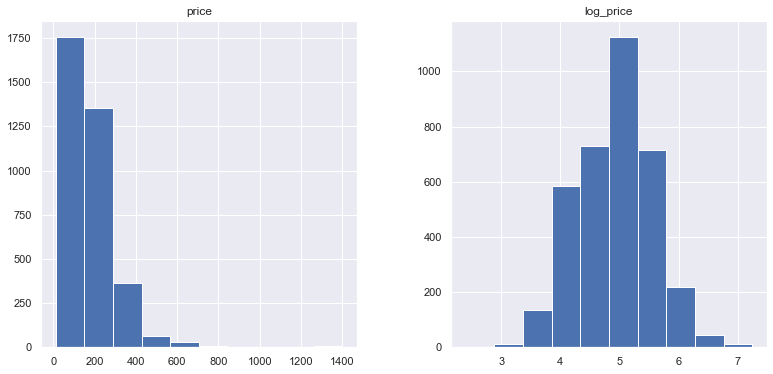

In [34]:
#since the price is right-skewed(positive skewness), we have to normalize the distribution
price = pd.DataFrame({'price': listings['price'], 'log_price': np.log1p(listings['price'])})
price.hist()

In [35]:
listings['log_price'] = np.log1p(listings['price'])

# Modeling

In [36]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV, LinearRegression

In [37]:
listings.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,n_amenities,log_price
count,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3.583000e+03,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000
mean,94.989082,84.173089,58.934692,58.934692,42.340027,-71.084827,3.040748,1.221491,1.255807,1.608842,172.069216,68.380145,1.429807,10.878314,3.171086,2.874124e+04,8.650851,21.836729,38.562657,179.352777,19.055261,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,12.740441,1.970908,15.858498,4.947792
std,11.669462,20.303447,171.161957,171.161957,0.024409,0.031564,1.779282,0.500464,0.752103,1.010713,125.277945,42.657878,1.057015,19.131090,8.876410,1.670602e+06,10.436859,21.863489,33.159150,142.120171,35.578740,8.383496,0.818131,1.027234,0.670024,0.646324,0.793316,0.888032,29.421980,1.884203,4.830206,0.642513
min,0.000000,0.000000,0.000000,0.000000,42.235942,-71.171789,1.000000,0.000000,0.000000,0.000000,10.000000,5.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.010000,1.000000,2.397895
25%,94.989082,79.000000,1.000000,1.000000,42.329990,-71.105100,2.000000,1.000000,1.000000,1.000000,85.000000,40.000000,1.000000,0.000000,1.000000,3.650000e+02,0.000000,0.000000,0.000000,19.000000,1.000000,91.000000,9.000000,9.000000,9.646293,9.646549,9.000000,9.000000,1.000000,0.640000,13.000000,4.454347
50%,100.000000,91.000000,2.000000,2.000000,42.345192,-71.078429,2.000000,1.000000,1.000000,1.000000,150.000000,68.380145,1.000000,0.000000,2.000000,1.125000e+03,4.000000,16.000000,37.000000,179.000000,5.000000,92.000000,9.431571,9.258041,10.000000,10.000000,9.414043,9.168234,2.000000,1.910000,16.000000,5.017280
75%,100.000000,100.000000,7.000000,7.000000,42.354687,-71.062168,4.000000,1.000000,2.000000,2.000000,220.000000,80.000000,1.000000,20.000000,3.000000,1.125000e+03,15.000000,40.000000,68.500000,325.000000,21.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.000000,2.130000,19.000000,5.398163
max,100.000000,100.000000,749.000000,749.000000,42.389982,-71.000100,16.000000,6.000000,5.000000,16.000000,1400.000000,300.000000,14.000000,200.000000,300.000000,1.000000e+08,30.000000,60.000000,90.000000,365.000000,404.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,136.000000,19.150000,31.000000,7.244942


In [38]:
#finally let's put all relevant information together for the modeling
model_df = listings[['host_response_time', 'host_acceptance_rate'
                    , 'host_is_superhost'
                    , 'host_total_listings_count', 'accommodates', 'bathrooms'
                    , 'bedrooms', 'beds', 'price', 'cleaning_fee', 'guests_included'
                    #, 'availability_30', 'availability_60', 'availability_90', 'availability_365' 
                    , 'number_of_reviews', 'review_scores_rating'
                    , 'reviews_per_month'
                    , 'room_type'
                    , 'neighbourhood_cleansed'
                    , 'cancellation_policy'
                    , 'property_type', 'n_amenities', 'log_price']]

In [39]:
#dataframe for natural language process to filter out words that might be relevant to customers
nlp_df = listings[['name', 'summary', 'description']]

In [40]:
model_df.dtypes

host_response_time            object
host_acceptance_rate         float64
host_is_superhost             object
host_total_listings_count      int64
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
price                          int64
cleaning_fee                 float64
guests_included                int64
number_of_reviews              int64
review_scores_rating         float64
reviews_per_month            float64
room_type                     object
neighbourhood_cleansed        object
cancellation_policy           object
property_type                 object
n_amenities                    int64
log_price                    float64
dtype: object

In [41]:
X = model_df.drop(['price', 'log_price'], axis=1)
y = model_df['log_price']

In [42]:
# ct = make_column_transformer(
#     (OneHotEncoder(), ['host_response_time'
#                        , 'host_is_superhost', 'room_type', 'neighbourhood_cleansed', 'cancellation_policy'
#                        , 'property_type']), remainder='passthrough')

# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['host_response_time'
#                         , 'host_is_superhost'
#                         , 'room_type'
#                         #, 'neighbourhood_cleansed'
#                         , 'cancellation_policy'
#                         , 'property_type'])], remainder='passthrough')

# X = np.array(ct.fit_transform(X))

In [43]:
cat_df = X.select_dtypes(include=['object'])
num_df = X.drop(cat_df.columns, axis=1)

In [44]:
cat_df_dummies = pd.get_dummies(cat_df, dummy_na=False)
cat_df_dummies.columns

Index(['host_response_time_a few days or more',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_is_superhost_f',
       'host_is_superhost_t', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_cleansed_Allston', 'neighbourhood_cleansed_Back Bay',
       'neighbourhood_cleansed_Bay Village',
       'neighbourhood_cleansed_Beacon Hill', 'neighbourhood_cleansed_Brighton',
       'neighbourhood_cleansed_Charlestown',
       'neighbourhood_cleansed_Chinatown', 'neighbourhood_cleansed_Dorchester',
       'neighbourhood_cleansed_Downtown', 'neighbourhood_cleansed_East Boston',
       'neighbourhood_cleansed_Fenway', 'neighbourhood_cleansed_Hyde Park',
       'neighbourhood_cleansed_Jamaica Plain',
       'neighbourhood_cleansed_Leather District',
       'neighbourhood_cleansed_Longwood Medical Area',
       'neighbourhood_cleansed_Mattapan',
  

In [45]:
X_new = pd.concat([cat_df_dummies, num_df], axis=1)

In [46]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=1)

In [47]:
#Standardize the numerical features
sc = StandardScaler()
X_train.iloc[ :, 51:] = sc.fit_transform(X_train.iloc[ :, 51:])
X_test.iloc[ :, 51:] = sc.transform(X_test.iloc[ :, 51:])

# from sklearn.preprocessing import MinMaxScaler

# mms = MinMaxScaler()
# X_train = mms.fit_transform(X_train)
# X_test = mms.transform(X_test)

In [48]:
alphas = 10**np.linspace(-3,3,100)
from sklearn.metrics import mean_squared_error
ridge_cofficients = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha, normalize=True)
    ridge.fit(X_train, y_train)
    ridge_cofficients.append(ridge.coef_)

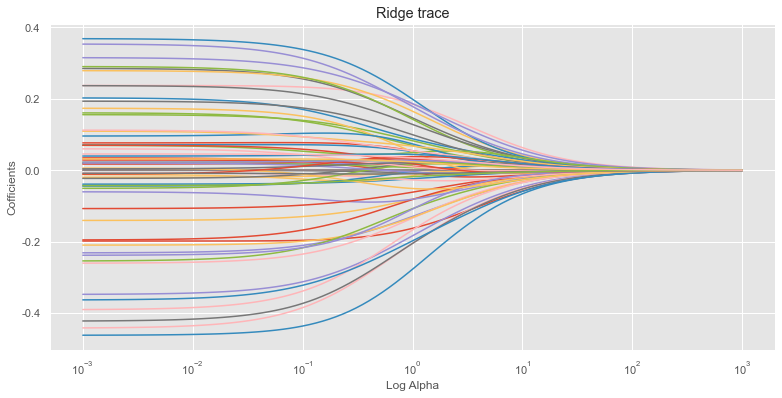

In [49]:
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
plt.plot(alphas, ridge_cofficients)
plt.xscale('log')
plt.axis('tight')
plt.title('Ridge trace')
plt.xlabel('Log Alpha')
plt.ylabel('Cofficients')
plt.show()    

In [50]:
# coss-validation test
ridge_cv = RidgeCV(alphas = alphas, normalize=True, cv = 10,scoring="neg_mean_squared_error")
ridge_cv.fit(X_train, y_train)
# best lambda
ridge_cv.alpha_

0.02848035868435802

In [51]:
model_ridge=Ridge(alpha = ridge_cv.alpha_)
model_ridge.fit(X_train,y_train)
pred_ridge= model_ridge.predict(X_test)

# evaluate the result
rmse = np.sqrt(metrics.mean_squared_error(y_test,pred_ridge))
r_square = metrics.r2_score(y_test, pred_ridge)
print('For test data set our final result is:')
print('RMSE {}'.format(rmse ))
print('R^2 is {}'.format(r_square))

For test data set our final result is:
RMSE 0.390222721579308
R^2 is 0.6461663430821958


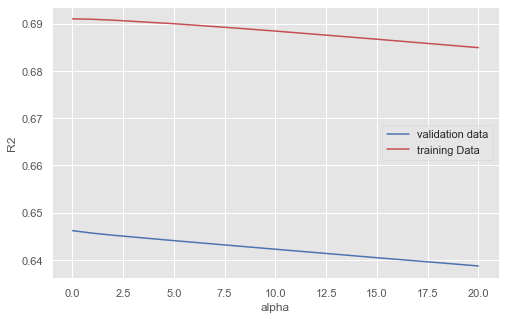

In [52]:
RR_square = []
RR_train = []
alpha = [0.0001, 0.001, 0.1, 1, 2,5,8,10, 15,20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(X_train, y_train)
    RR_square.append(RigeModel.score(X_test, y_test))
    RR_train.append(RigeModel.score(X_train, y_train))
    
# visualize
plt.figure(figsize=(8, 5))
plt.plot(alpha,RR_square,'b' ,label='validation data')
plt.plot(alpha,RR_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R2')
plt.legend();

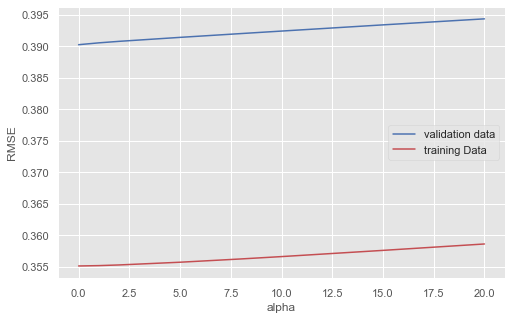

In [53]:
RMSE_valid = []
RMSE_train = []
alpha = [0.0001, 0.001, 0.1, 1, 2,5,8,10, 15,20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(X_train, y_train)
    RMSE_valid.append(np.sqrt(mean_squared_error(y_test, RigeModel.predict(X_test))))
    RMSE_train.append(np.sqrt(mean_squared_error(y_train, RigeModel.predict(X_train))))    
    
    
# visualize
plt.figure(figsize=(8, 5))
plt.plot(alpha,RMSE_valid,'b' ,label='validation data')
plt.plot(alpha,RMSE_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend();

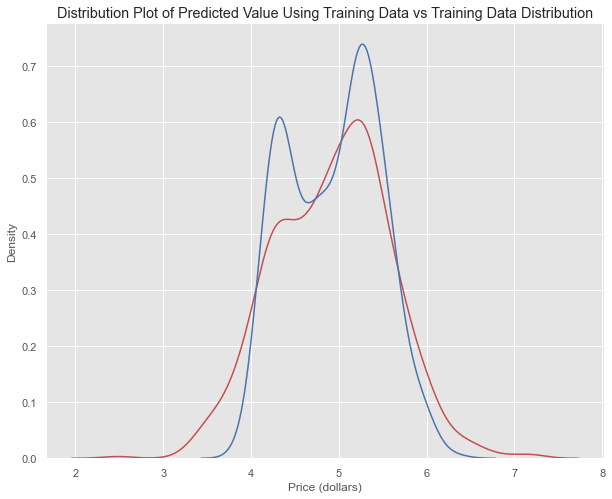

In [55]:
#Visualize model prediction
def DistributionPlot(RedFunction, BlueFunction, Title):
    '''
    INPUT:
        RedFunction: Input of your test set for the dependent variable y. Shows a distribution of the to predicted variable
        BlueFunction: Input of test set of the independent variable/s X to predict the dependent variable y.
        Herefore the Ridge Regression Model based on the performing lambda is applied on this model.
        Title: Choose a title which best describes the outcome of the visualised plot.
    OUTPUT:
        Distribution plot of predicted Value y using training data vs training data distribution
    '''
    plt.figure(figsize=(10, 8))
    ax1 = sns.distplot(RedFunction, hist=False, color="r")
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", ax=ax1)
    plt.title(Title)
    plt.xlabel('Price (dollars)')
    plt.show()
    plt.close()
DistributionPlot(y_test, pred_ridge, 
                 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution')

In [ ]:
# residual scatter plot
mpl.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [ ]:
np.corrcoef(model_ridge.predict(X_train),y_train)

In [ ]:
def rmse_cv(model):
    '''
    INPUT:
        model: Insert a defined statistical Machine Learning model. The inserted model must contain function call
    OUTPUT:
        Root mean squared error (RMSE), which is the square root of the mean of the square of all of the error.
        The result is based on the algortihm of the regression model you chose. The computation is applied on
        your define training size for the dependent and independent variable/s.
        P.S.: 1 - RMSE = Accuarcy
    '''
    return np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5))

In [ ]:
#Model 1 Linear Regression
model_lr = LinearRegression()
rmse_cv(model_lr).mean()

In [ ]:
#Model 2 Ridge Regression
model_ridge = RidgeCV(alphas=[1, 0.1, 0.01, 0.005])
rmse_cv(model_ridge).mean()

In [ ]:
#Model 2 Lasso Regression
model_lasso = LassoCV(alphas=[1, 0.1, 0.01, 0.005])
rmse_cv(model_lasso).mean()